[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbg-research/AI-Training/blob/main/voice-analytics/noise_suppression/Tutorial-2.ipynb)

# Speech Enhancement From Scratch

Let's introduce a bit the problem of speech enhancement. The goal of speech enhancement is to remove noise from an input recording:

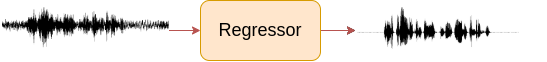

The problem is very hard because of the huge variety of disturbances that might corrupt speech signals.


There are different ways to approach the problem. Nowadays, one of the most popular technique is masked-based speech enhancement:

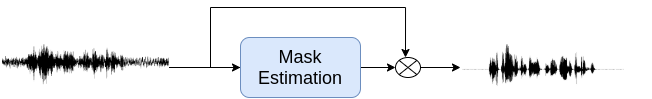

In masking approaches, rather than estimating the enhanced signal directly, we estimate a soft mask. We then estimate the enhanced signal by multiplying the noisy one by the soft mask. 

Depending on the type of input/output we can have:
- Waveform masking (depicted in the figure above)
- Spectral masking (depicted in the figure below)



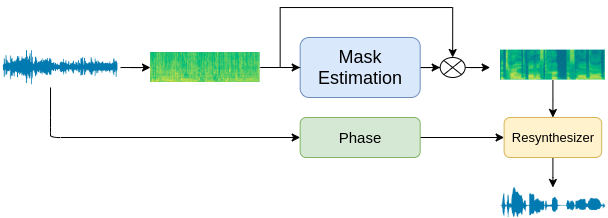

In spectral masking, the system maps noisy spectrograms into clean ones. This mapping is generally considered easier than waveform-to-waveform mapping. However, retrieving the signal in the time domain requires adding the phase information.

In this tutorial, we will guide you through the creation of a simple speech enhancement system based on spectral masking. 


In [1]:
%%capture

!pip install torchaudio
!pip install speechbrain
!pip install pesq
import speechbrain as sb

Prepare the data manifests and create the dataset objects using them with the function we defined earlier:

We can check that the data is being loaded correctly by seeing the first items:

In [2]:
!python3.8 train.py train.yaml --device='cpu'

data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/4234
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.core - 2.0M trainable parameters in SEBrain
speechbrain.utils.checkpoints - Loading a checkpoint from results/4234/save/CKPT+2021-11-01+03-28-26+00
speechbrain.utils.epoch_loop - Going into epoch 3
100%|█████████████████████████████████████████| 137/137 [00:48<00:00,  2.81it/s]
speechbrain.utils.train_logger - Epoch: 3 - train loss: 2.62e-02 - valid loss: 2.98e-02, valid stoi: 7.57e-01
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/4234/save/CKPT+2021-11-01+04-21-57+00
speechbrain.utils.checkpoints - Loading a checkpoint from results/4234/save/CKPT+2021-11-01+03-28-26+00
100%|█████████████████████████████████████████| 328/328 [02:09<00:00,  2.54it/s]
speechbrain.utils.train_logger - Epoch loaded: 2 - test loss: 3.25e-02, test stoi: 

### Inference

In [3]:
import soundfile as sf
import IPython
import torch
import torchaudio
from speechbrain.pretrained import SpectralMaskEnhancement

In [14]:
enhance_model = SpectralMaskEnhancement.from_hparams(
    source="best_model/",
    hparams_file='test.yaml',
    savedir="best_model/",
    
)

In [15]:
enhance_model.modules

<bound method Module.modules of SpectralMaskEnhancement(
  (mods): ModuleDict(
    (enhance_model): CustomModel(
      (layers): ModuleList(
        (0): LSTM(257, 256, bidirectional=True)
        (1): Linear(in_features=512, out_features=128, bias=True)
        (2): LSTM(128, 256, bidirectional=True)
        (3): Linear(in_features=512, out_features=257, bias=True)
        (4): ReLU()
      )
    )
  )
)>

In [5]:
# Load and add fake batch dimension
noisy = enhance_model.load_audio(
    "noise_sample.wav"
).unsqueeze(0)

In [6]:
# Add relative length tensor
enhanced = enhance_model.enhance_batch(noisy)

In [7]:
# Saving enhanced signal on disk
torchaudio.save('enhanced.wav', enhanced.cpu(), 16000)

In [8]:
# load data
audio = "enhanced.wav"
data, rate = sf.read(audio)
data = data
# displaying the audio file 
IPython.display.Audio(data=data, rate=rate)

### Inference - MetricGAN

In [16]:
enhance_model = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir="pretrained_models/metricgan-plus-voicebank",
)

In [17]:
enhance_model.modules

<bound method Module.modules of SpectralMaskEnhancement(
  (mods): ModuleDict(
    (enhance_model): EnhancementGenerator(
      (activation): LeakyReLU(negative_slope=0.3)
      (blstm): LSTM(
        (rnn): LSTM(257, 200, num_layers=2, batch_first=True, bidirectional=True)
      )
      (linear1): Linear(in_features=400, out_features=300, bias=True)
      (linear2): Linear(in_features=300, out_features=257, bias=True)
      (Learnable_sigmoid): Learnable_sigmoid()
      (sigmoid): Sigmoid()
    )
  )
)>

In [10]:
# Load and add fake batch dimension
noisy = enhance_model.load_audio(
    "noise_sample.wav"
).unsqueeze(0)

In [11]:
# Add relative length tensor
enhanced = enhance_model.enhance_batch(noisy, lengths=torch.tensor([1.]))

In [12]:
# Saving enhanced signal on disk
torchaudio.save('enhanced.wav', enhanced.cpu(), 16000)

In [13]:
# load data
audio = "enhanced.wav"
data, rate = sf.read(audio)
data = data
# displaying the audio file 
IPython.display.Audio(data=data, rate=rate)